In [95]:
import yfinance as yf
gold = yf.download('BTC-USD', '2022-03-01', '2024-03-01', auto_adjust=True)

print(gold)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: No data found for this date range, symbol may be delisted
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


Chuyển Date thành Timestamp

In [96]:

gold['Date'] = gold.index
gold.set_index('Date')
print(gold)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date]
Index: []


Tạo thêm các cột MA7, MA25, MA99

In [97]:
# Tính toán và tạo cột cho trung bình động 7 ngày (MA7)
gold['MA7'] = gold['Close'].rolling(window=7).mean()

# Tính toán và tạo cột cho trung bình động 25 ngày (MA25)
gold['MA25'] = gold['Close'].rolling(window=25).mean()

# Tính toán và tạo cột cho trung bình động 99 ngày (MA99)
gold['MA99'] = gold['Close'].rolling(window=99).mean()

# In ra DataFrame để kiểm tra kết quả
print(gold)


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date, MA7, MA25, MA99]
Index: []


In [98]:
# Thay thế các giá trị NaN bằng 0
gold.fillna(0, inplace=True)

# In ra DataFrame để kiểm tra kết quả
print(gold)


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date, MA7, MA25, MA99]
Index: []


Chia tập train và tập test

Mô hình PROPHET

In [99]:
# !conda install libpython m2w64-toolchain -c msys2

In [100]:
# !pip install --upgrade wheel

In [101]:
# !pip install pystan

In [102]:
# !conda install -c conda-forge prophet

In [103]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
df = gold
def calculate_ma(df, window, name):
  
    return df[name].rolling(window=window).mean().fillna(0)

def calculate_boll(df, window):
    sma = df['Close'].rolling(window=window).mean().fillna(0)
    rolling_std = df['Close'].rolling(window=window).std().fillna(0)
    upper_band = sma + (2 * rolling_std)
    lower_band = sma - (2 * rolling_std)
    return upper_band, lower_band



def calculate_kd(df, window_slow, window_fast):
    low_min = df['Low'].rolling(window=window_slow).min()
    high_max = df['High'].rolling(window=window_slow).max()
    k = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=window_fast).mean().fillna(0)
    return k, d

def calculate_sar(df, acceleration=0.02, maximum=0.2):
    high = df['High']
    low = df['Low']
    close = df['Close']
    sar = pd.Series(index=df.index)
    sar[0] = low[0]
    trend = 0
    ep = 0
    af = acceleration
    for i in range(1, len(df)):
        if trend == 0:
            if high[i - 1] > high[i] and low[i - 1] > low[i]:
                trend = 1
                sar[i] = low[i]
                ep = high[i]
                af = acceleration
            elif high[i - 1] < high[i] and low[i - 1] < low[i]:
                trend = -1
                sar[i] = high[i]
                ep = low[i]
                af = acceleration
        else:
            if trend == 1:
                if high[i] > ep:
                    sar[i] = sar[i - 1] + af * (ep - sar[i - 1])
                    sar[i] = min(sar[i], low[i - 1])
                    ep = high[i]
                    af = min(af + acceleration, maximum)
                else:
                    trend = -1
                    sar[i] = ep
                    sar[i] = min(sar[i], low[i - 1])
                    sar[i] = min(sar[i], low[i])
                    ep = low[i]
                    af = acceleration
            elif trend == -1:
                if low[i] < ep:
                    sar[i] = sar[i - 1] + af * (ep - sar[i - 1])
                    sar[i] = max(sar[i], high[i - 1])
                    ep = low[i]
                    af = min(af + acceleration, maximum)
                else:
                    trend = 1
                    sar[i] = ep
                    sar[i] = max(sar[i], high[i - 1])
                    sar[i] = max(sar[i], high[i])
                    ep = high[i]
                    af = acceleration
    return sar
# Load data
# Replace 'your_data.csv' with your own data file
df = gold
print(df)
# Preprocess data (fill missing values, convert types, etc.)
# Replace any preprocessing steps here


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date, MA7, MA25, MA99]
Index: []


In [104]:

# Calculate technical indicators
df['MA_50'] = calculate_ma(df, 50,'Close')


In [105]:
upper_band, lower_band = calculate_boll(df, 20)
print(df)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date, MA7, MA25, MA99, MA_50]
Index: []


In [106]:
df['Bollinger_Upper'] = upper_band
df['Bollinger_Lower'] = lower_band
k, d = calculate_kd(df, 14, 3)
print(df)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, Date, MA7, MA25, MA99, MA_50, Bollinger_Upper, Bollinger_Lower]
Index: []


In [107]:
df['Stochastic_Oscillator_K'] = k
df['Stochastic_Oscillator_D'] = d
df['Parabolic_SAR'] = calculate_sar(df)
print(df)


C:\Users\My My\AppData\Local\Temp\ipykernel_26328\2109818831.py:30: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sar = pd.Series(index=df.index)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
df2=df.copy()
df2['y']=df2['Close']
# Selecting relevant columns (Prophet requires a DataFrame with 'ds' and 'y' columns)
df2 = df2[['Date', 'Close','y', 'MA25', 'MA7', 'MA99', 'Parabolic_SAR']].rename(columns={'Date': 'ds'})
print(df2)



                   ds         Close             y          MA25           MA7  \
Date                                                                            
2022-03-01 2022-03-01  44354.636719  44354.636719      0.000000      0.000000   
2022-03-02 2022-03-02  43924.117188  43924.117188      0.000000      0.000000   
2022-03-03 2022-03-03  42451.789062  42451.789062      0.000000      0.000000   
2022-03-04 2022-03-04  39137.605469  39137.605469      0.000000      0.000000   
2022-03-05 2022-03-05  39400.585938  39400.585938      0.000000      0.000000   
...               ...           ...           ...           ...           ...   
2024-02-25 2024-02-25  51733.238281  51733.238281  48442.764375  51606.351562   
2024-02-26 2024-02-26  54522.402344  54522.402344  48900.629531  51998.245536   
2024-02-27 2024-02-27  57085.371094  57085.371094  49456.610000  52684.030692   
2024-02-28 2024-02-28  62504.789062  62504.789062  50237.111563  54207.689174   
2024-02-29 2024-02-29  61198

In [ ]:
X = df2[['ds', 'Close','y', 'MA7', 'MA25', 'MA99', 'Parabolic_SAR']]
y = df2['y']

# Tạo một điểm chia dữ liệu giả định
split_point = int(len(df2) * 0.7)  # 70% là tập huấn luyện

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(len(X_train), len(X_test))


511 220


In [ ]:

# Prophet model training
prophet_model = Prophet()
prophet_model.add_regressor('Parabolic_SAR')
prophet_model.fit(df2)



17:05:34 - cmdstanpy - INFO - Chain [1] start processing
17:05:34 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
print(X_test)

                   ds         Close             y           MA7          MA25  \
Date                                                                            
2023-07-25 2023-07-25  29227.390625  29227.390625  29696.476004  30241.372891   
2023-07-26 2023-07-26  29354.972656  29354.972656  29616.625837  30191.968672   
2023-07-27 2023-07-27  29210.689453  29210.689453  29533.579241  30135.565469   
2023-07-28 2023-07-28  29319.246094  29319.246094  29449.365234  30062.077734   
2023-07-29 2023-07-29  29356.917969  29356.917969  29390.095982  30005.251172   
...               ...           ...           ...           ...           ...   
2024-02-25 2024-02-25  51733.238281  51733.238281  51606.351562  48442.764375   
2024-02-26 2024-02-26  54522.402344  54522.402344  51998.245536  48900.629531   
2024-02-27 2024-02-27  57085.371094  57085.371094  52684.030692  49456.610000   
2024-02-28 2024-02-28  62504.789062  62504.789062  54207.689174  50237.111563   
2024-02-29 2024-02-29  61198

In [ ]:

# Make predictions
print(X_test)

                   ds         Close             y           MA7          MA25  \
Date                                                                            
2023-07-25 2023-07-25  29227.390625  29227.390625  29696.476004  30241.372891   
2023-07-26 2023-07-26  29354.972656  29354.972656  29616.625837  30191.968672   
2023-07-27 2023-07-27  29210.689453  29210.689453  29533.579241  30135.565469   
2023-07-28 2023-07-28  29319.246094  29319.246094  29449.365234  30062.077734   
2023-07-29 2023-07-29  29356.917969  29356.917969  29390.095982  30005.251172   
...               ...           ...           ...           ...           ...   
2024-02-25 2024-02-25  51733.238281  51733.238281  51606.351562  48442.764375   
2024-02-26 2024-02-26  54522.402344  54522.402344  51998.245536  48900.629531   
2024-02-27 2024-02-27  57085.371094  57085.371094  52684.030692  49456.610000   
2024-02-28 2024-02-28  62504.789062  62504.789062  54207.689174  50237.111563   
2024-02-29 2024-02-29  61198

In [ ]:
n_days = 30  # Số ngày muốn dự báo tiếp theo sau bộ kiểm tra
future_dates = pd.date_range(start=X_test.index[-1], periods=n_days + 1, closed='right')  # Tạo các thời điểm trong khoảng thời gian mới

# Tạo DataFrame mới cho dự báo với cột 'Parabolic_SAR' được thêm vào
future_df = pd.DataFrame({'ds': future_dates, 'Parabolic_SAR': X_test['Parabolic_SAR'][-1] * len(future_dates)})

# Sử dụng phương thức predict để dự báo cho các thời điểm mới
forecast = prophet_model.predict(future_df)


C:\Users\My My\AppData\Local\Temp\ipykernel_26328\2322332905.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=X_test.index[-1], periods=n_days + 1, closed='right')  # Tạo các thời điểm trong khoảng thời gian mới


In [ ]:
# forecast = prophet_model.predict(X_test)
# # print(X_train)
# print(forecast)

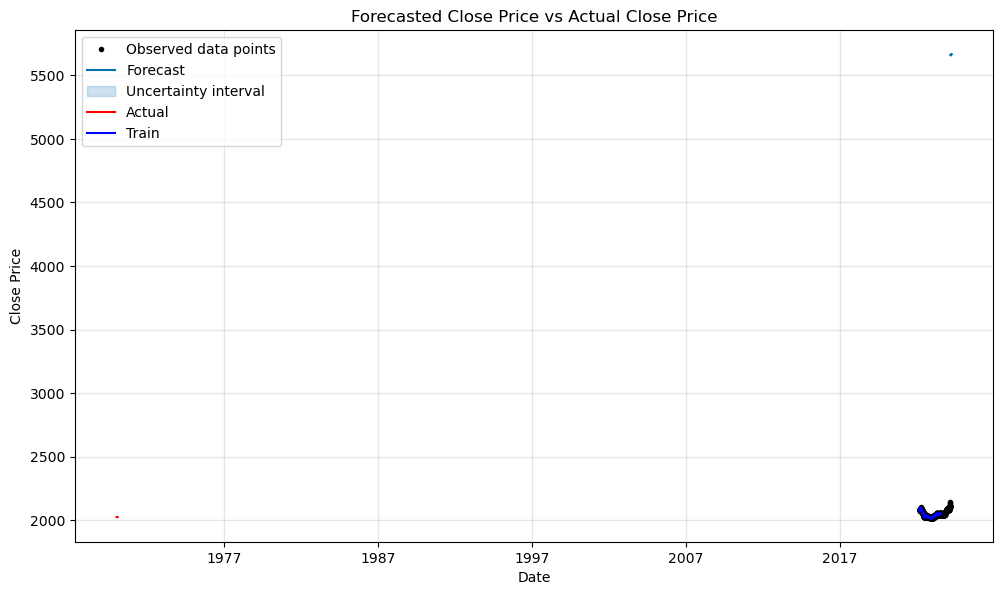

In [ ]:
# Visualize results
prophet_model.plot(forecast)

# Plot actual values from y_test
plt.plot(forecast['ds'], y_train, label='Actual', color='red')  # Using forecasted dates for plotting

# Plot training data
plt.plot(X_train.index, y_train, label='Train', color='blue')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Close Price vs Actual Close Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, forecast['yhat'])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast['yhat'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

ValueError: Found input variables with inconsistent numbers of samples: [220, 30]

In [ ]:
y_true = X_test['y']
y_pred = forecast['yhat']
r_squared = r2_score(y_true, y_pred)

print("R-squared:", r_squared)

NameError: name 'r2_score' is not defined